<a href="https://colab.research.google.com/github/TransRadOnc-HIT/multi-omics-SSMP2023/blob/main/Hands_on_3_MachineLearningView_MOFA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine learning view to multi-omics integration 2 -  multi-omics Factor Analysis (MOFA)

This notebook is dedicated to the exploration and application of Multi-omics Factor Analysis (MOFA) on the dataset derived from the TCGA GBM cohort. The dataset has already been preprocessed for our analysis.

## Data Reference:
- [The Cancer Imaging Archive (TCGA GBM cohort)](https://portal.gdc.cancer.gov/projects/TCGA-GBM)

While there is **no immediate necessity to download the dataset**, those who are interested in obtaining it directly can download from the provided link. Should you choose to do this, please adjust the `data_path` variable to align with the directory where your dataset is located.

## About MOFA:
For more on MOFA, you can find comprehensive information and resources on the [official MOFA website](https://biofam.github.io/MOFA2/index.html).

## Omics Types Under Investigation:
- Clinical Data
- T1w-preCA Imaging Data
- T1w-postCA Imaging Data
- T2w-FLAIR Imaging Data
- T2w Imaging Data
- Genomic Data
- Methylation Data
- miRNA Data


### **Setup**
We will quickly install the necessary packages which do not come with Google Colab direclty, load the necessary imports and set the data path.

In [ ]:
!pip install lifelines mofapy2 mofax pyqt5

Let's continue with the necessary imports and setting the `data_path`.

In [ ]:
# Integrating with Google Drive, in case you want to download the data or add some of your own - uncomment
# from google.colab import drive
# drive.mount('/content/drive')

import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from collections import Counter
from os import path
import os
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import MinMaxScaler
from lifelines import KaplanMeierFitter
from mofapy2.run.entry_point import entry_point
from itertools import combinations
from collections import Counter #Supports iterations

warnings.filterwarnings('ignore') #Ignores all warnings


data_path = 'https://raw.githubusercontent.com/TransRadOnc-HIT/multi-omics-SSMP2023/main/data/hands-on3'

# Please use this data_path and adapt it if you download the data or use your own later
# data_path = '/content/drive/MyDrive/your_data_folder_path_here/'

### **Data loading and preparation**
First, we will load the preprocessed data (.csv files) as Pandas dataframes. With the following function we will get:
- 1 DataFrame containing the clinical data
- 2 DataFrames for testing, 1 containing only clinical data, 1 containing everything else without clinical data
- 1 dictionary containing all the other dataframes without clinical data


In [ ]:
files = [
    "CLI_preprocessed.csv",
    "FLAIR_GENE_METHY_MIRNA_T1_T1Gd_T2.mofa.hdf5",
    "FLAIR_preprocessed.csv",
    "GENE_preprocessed.csv",
    "METHY_preprocessed.csv",
    "MIRNA_preprocessed.csv",
    "T1Gd_preprocessed.csv",
    "T1_preprocessed.csv",
    "T2_preprocessed.csv",
    "clinical.csv",
    "survival.csv",
    "test_dataframe_preprocessed.csv"
]

In [ ]:
def load_processed_dataframes(files, directory="."):
    """
    Load the files from a directory which contain '_preprocessed' in their name.
    Split them into a clinical data dataframe, testing data with and without clinical dataframes, and a dictionary with everything else.

    Parameters:
      directory (str): Directory to load the CSV files from. Defaults to the current directory.

    Returns:
      cli_dataframe: Dataframe containing the CLI data.
      test_dataframe_cli: Portion of the test dataframe containing only CLI features.
      test_dataframe_other: Portion of the test dataframe containing features other than CLI.
      dict: Dictionary containing other dataframes loaded from CSV files.
    """

    dataframes = {
        "FLAIR": None,
        "GENE": None,
        "METHY": None,
        "MIRNA": None,
        "T1": None,
        "T1Gd": None,
        "T2": None
    }

    cli_dataframe = None
    test_dataframe_cli = None
    test_dataframe_other = None

    # First, specifically load the CLI dataframe
    if "CLI_preprocessed.csv" in files:
        cli_dataframe = pd.read_csv(f"{directory}/CLI_preprocessed.csv", index_col=0)
        print(f"Loaded: CLI_preprocessed.csv with shape {cli_dataframe.shape}")
    else:
        raise ValueError("CLI_preprocessed.csv not found in the specified directory.")

    for file_name in files:
        if "_preprocessed.csv" in file_name and file_name != "CLI_preprocessed.csv": # We already loaded CLI
            key = file_name.replace("_preprocessed.csv", "")
            dataframe = pd.read_csv(f"{directory}/{file_name}", index_col=0)

            if key == "test_dataframe":
                test_dataframe_cli = dataframe[dataframe.columns.intersection(cli_dataframe.columns)]
                test_dataframe_other = dataframe.drop(test_dataframe_cli.columns, axis=1)
                print(f"Loaded: {file_name} and split it into CLI and other data with shapes {test_dataframe_cli.shape} and {test_dataframe_other.shape}")

            elif key in dataframes:
                dataframes[key] = dataframe
                print(f"Loaded: {file_name} with shape {dataframe.shape}")

    return cli_dataframe, test_dataframe_cli, test_dataframe_other, dataframes

cli_dataframe, test_dataframe_cli, test_dataframe_other, dataframes  =  load_processed_dataframes(files, data_path)

In [ ]:
for key, df in dataframes.items():
    if df is not None:  # Check if the dataframe is not empty
        missing_ids = df.index.difference(cli_dataframe.index)

        if not missing_ids.empty:
            dataframes[key] = df.drop(missing_ids)  # Remove the missing IDs from the dataframe
            print(f"Removed IDs not present in cli_dataframe from {key} dataframe.")
        else:
            print(f"All IDs in {key} dataframe are present in cli_dataframe.")


We will now create all possible combinations of omics datasets.

In [ ]:
def generate_omics_combinations(dataframes_dict):
  """
  The function is designed to create a list of unique combinations from a dictionary of omics datasets.
  It will generate all possible combinations of omics datasets, considering different groupings from a
  single omics dataset to all available omics datasets.
  These combinations are sorted and stored in a list.

  Parameters:
    dataframes_dict (dict): A dictionary where keys represent the names of omics datasets, and values
    represent the corresponding dataframes.

  Returns:
    list: A list containing unique combinations of omics datasets, sorted in a specific order.

  """
  omics_combinations = set()
  for r in range(1, len(dataframes_dict) + 1):
      for combo in combinations(dataframes_dict.keys(), r):
          sorted_combo = tuple(sorted(combo))
          omics_combinations.add(sorted_combo)

  return list(omics_combinations)

#
# omics_combinations = generate_omics_combinations(dataframes)
omics_combinations = [('FLAIR', 'GENE','METHY','MIRNA','T1','T1Gd','T2')]

### **Initialize and train MOFA models**
Next, we will:
- calculate weights in case different omics layers have different number of features
- create MOFA compatible dataframes which will include the different combinations we returned earlier (everything without clinical), further called MOFA models (.hdf5 files). This means training the model.

*Note*: You do not have to run this cell, as the training might take a little bit of time (around 5 minutes). We are loading the already trained and saved model in the next cell, but if you want you can of course look around and run the training.


In [ ]:
def calculate_weights(dataframes_dict, omics_list):
    """
    The function serves the purpose of computing normalized weights based on the number
    of columns (features) in specified datasets. It is particularly useful when dealing with
    multiple datasets or omics types in a data analysis context. The function calculates weights
    that can be used to balance the influence of different datasets in subsequent analyses.

    Parameters:
      dataframes_dict (dict): A dictionary where keys represent the names of datasets or omics types,
                              and values represent the corresponding dataframes.
      omics_list (list): A list containing the names of the selected datasets or omics types for which
                        weights need to be calculated.

    Returns:
      list: A list of normalized weights, one for each dataset in the omics_list.
            These weights are proportional to the number of features in each dataset and are normalized
            to ensure their sum equals the total number of datasets.
    """

    # Extracting number of columns (features) for selected datasets
    num_features = [dataframes_dict[omics].shape[1] for omics in omics_list]

    # Calculating inverse weights
    inverse_weights = [1.0/feat for feat in num_features]

    # Normalizing the weights
    total_datasets = len(omics_list)
    normalized_weights = [total_datasets * weight/sum(inverse_weights) for weight in inverse_weights]

    return normalized_weights

def create_mofa_dataframe(dataframes_dict, omics_list):
  """
  The function is designed to construct a unified dataframe suitable for Multi-Omics Factor Analysis (MOFA)
  from a collection of omics datasets. MOFA is a technique used in bioinformatics and data analysis to integrate
  multiple omics data sources for exploration and modeling. This function facilitates the conversion of separate
  omics dataframes into a single format compatible with MOFA.

  Parameters:
    dataframes_dict (dict): A dictionary where keys represent the names of omics datasets, and values represent
                            the corresponding dataframes.
    omics_list (list): A list containing the names of the omics datasets to be included in the unified MOFA dataframe.

  Returns:
    pandas.DataFrame: A single, concatenated dataframe containing data from the specified omics datasets,
                      appropriately formatted for MOFA analysis.
  """

  data_list = []
  for omics_name in omics_list:
      df = dataframes_dict[omics_name]
      df_reset = df.reset_index().rename(columns={'index': 'sample'})

      melted = df_reset.melt(id_vars='sample', var_name="feature", value_name="value")
      melted = melted.dropna(subset=['value'])  # Drop rows with NaN in 'value' column
      melted['view'] = omics_name
      melted['group'] = "group1"
      data_list.append(melted)
  return pd.concat(data_list, ignore_index=True)

# Looping through all the combinations and saving each created dataframe as a .mofa.hdf5 model file.
for omics_list in omics_combinations:
    print("Training for omics combination:", omics_list)

    # Set likelihoods based on omics_list
    likelihoods = ["gaussian" if omic != "CLI" else "bernoulli" for omic in omics_list]
    outfile_name = "_".join(omics_list) + ".mofa.hdf5"
    # outfile_name = path.join(data_path, outfile_name)

    if not os.path.isfile(outfile_name):
        # Initialize the entry point
        ent = entry_point()
        ent.set_data_options(scale_views=False)
        #Weighted MOFA
        weights = calculate_weights(dataframes, omics_list)
        mofa_dataframe = create_mofa_dataframe(dataframes, omics_list)
        mofa_dataframe['value'] = mofa_dataframe['value'].astype(float)
        ent.set_data_df(mofa_dataframe, likelihoods=likelihoods)
        ent.set_model_options(factors = 10, spikeslab_weights = True, ard_weights = True)
        ent.set_train_options(convergence_mode = "fast", dropR2 = 0.001, gpu_mode = True, seed = 1, weight_views=weights)
        # Modify the outfile name based on the omics combination
        outfile_name = "_".join(omics_list) + ".mofa.hdf5"
        # outfile_name = path.join(data_path, outfile_name)

        ent.build()
        ent.run()
        ent.save()

### **Load MOFA models, add metadata**
We will now load all the previously created MOFA models.

In [ ]:
import mofax as mfx
import tempfile
import requests

def load_all_mofa_models(path_or_directory):
  """
  The function is designed to load multiple Multi-Omics Factor Analysis (MOFA) models
  stored in a specified directory. It systematically searches the given directory
  for MOFA model files, loads each model, and stores them in a dictionary for convenient
  access and further analysis.

  Parameters:
    directory (str): The directory path where MOFA model files are located.

  Returns:
    dict: A dictionary where keys represent the names of the MOFA models (derived
          from the file names), and values are the corresponding loaded MOFA models.
  """
    # Create an empty dictionary to store the models
  models = {}

  if 'tmp' in path_or_directory and path_or_directory.endswith('.hdf5'):
          # If the path contains 'temp' and is a file, load the model directly from the temp path; this is a hard-coded line only for this workshop,
          # if you want to use it later, please modify it accordingly
          models['FLAIR_GENE_METHY_MIRNA_T1_T1Gd_T2'] = mfx.mofa_model(path_or_directory)
  elif os.path.isdir(path_or_directory):
      # If it's a directory, search for MOFA model files
      directory = path_or_directory
      for filename in os.listdir(directory):
          if filename.endswith('.mofa.hdf5'):
              filepath = os.path.join(directory, filename)
              # Load the MOFA model and store it in the dictionary
              models[filename.split('.mofa.hdf5')[0]] = mfx.mofa_model(filepath)
  elif path_or_directory.endswith('.mofa.hdf5'):
      # If it's a file with the correct extension, load it directly
      response = requests.get(path_or_directory)
      if response.status_code == 200:
          # Create a temporary file to save the downloaded content
          with tempfile.NamedTemporaryFile(delete=False) as temp_file:
              temp_file.write(response.content)
              temp_file_path = temp_file.name

          # Now you can create an mofa_model from the downloaded file
          models[os.path.basename(path_or_directory).split('.mofa.hdf5')[0]] = mfx.mofa_model(temp_file_path)

          # After you're done, you can remove the temporary file
          os.remove(temp_file_path)
      else:
          print('Failed to download the file from GitHub.')
  else:
      raise ValueError("Invalid path or directory. Please provide a valid path to a directory or a MOFA model file.")

  return models

# We are loading the already trained model
# all_models = load_all_mofa_models(data_path + '/FLAIR_GENE_METHY_MIRNA_T1_T1Gd_T2.mofa.hdf5')
all_models = load_all_mofa_models('/tmp/mofa_20230919-163731.hdf5')
# If you ran the previous cell and trained the model, you can load your trained model from the temp folder, just replace the name of the model mofa_
# m = mfx.mofa_model('/tmp/mofa_20230919-163731.hdf5')
# In the interest of time, we will further use only one of the combinations. It is of course interesting to check all
# of the different combinations.

m = all_models['FLAIR_GENE_METHY_MIRNA_T1_T1Gd_T2']
model_samples = m.get_samples()['sample']

We will now manipulate the dataframes containing clinical data and testing data to match the MOFA Dataframe based on a list of IDs.


In [ ]:
def reorder_dataframe_rows(df, ordered_ids):
    """
    Reorders the rows of the df dataframe based on the provided list of IDs ordered_ids.

    Parameters:
    - df (pd.DataFrame): The dataframe to be reordered.
    - ordered_ids (list): List of IDs specifying the desired order.

    Returns:
    - pd.DataFrame: The reordered dataframe with the index reset and a new column "sample" added, replacing the index column.
    """
    # Filter rows based on the IDs present in ordered_ids
    valid_ordered_ids = [id_ for id_ in ordered_ids if id_ in df.index]

    # Reorder rows based on the order of ordered_ids
    reordered_df = df.reindex(valid_ordered_ids)
    reordered_df.index.name = 'sample'

    return reordered_df

cli = reorder_dataframe_rows(cli_dataframe, model_samples)
test_dataframe_cli = reorder_dataframe_rows(test_dataframe_cli, model_samples)
test_dataframe_other = reorder_dataframe_rows(test_dataframe_other, model_samples)

Next, we are setting the clinical data as medatadata for the model.

In [ ]:
# Add metadata to the model
m.metadata = m.metadata.join(cli)
m.metadata = m.metadata.astype(str)

The modalities that we included in the analysis are T1-preCA, T1-postCA,T2w, T2w-FLAIR, genomics, methylation and miRNA. We can see the order of the layers in the views attribute of the model and later use that for visualizing the variance in each layer.

In [ ]:
m.get_views()

['FLAIR', 'GENE', 'METHY', 'MIRNA', 'T1', 'T1Gd', 'T2']

We can use the views with their order numbers: FLAIR = 0, GENE = 1, METHY = 2, etc. We will store them in a dictionary for easy access.

In [ ]:
omics_dict = {omics: index for index, omics in enumerate(m.get_views())}

### **Visualization and interpretation**


First we can quickly check the overall dimensions of the model

In [ ]:
print(f"""\
Cells: {m.shape[0]}
Features: {m.shape[1]}
Groups of cells: {', '.join(m.groups)}
Views: {', '.join(m.views)}
""")

# HDF5 group
print("HDF5 group:\n", m.weights)

# np.ndarray
print("\nnp.ndarray:\n", m.get_weights()[:3,:5])

# pd.DataFrame
print("\npd.DataFrame:\n", m.get_weights(df=True).iloc[:3,:5])

#### Heatmap
We can take a look at a global overview of top features by plotting a heatmap. Go ahead and take a look at different views (the omics layers) and different number of features by changing the parameter passed to `omics_dict`: string choosing from ['FLAIR', 'GENE', 'METHY', 'MIRNA', 'T1', 'T1Gd', 'T2'] and `n_features`: integer below.

In [ ]:
mfx.plot_weights_heatmap(m, n_features=3, view=omics_dict['T1'],
                         factors=range(0, 8),
                         xticklabels_size=6, w_abs=True,
                         cmap="viridis", cluster_factors=False)

We can also take a look at the most important features for each layer (modify again the layer as you wish):

In [ ]:
mfx.plot_weights_ranked(m, factor=1,size=10,label_size=10,view=omics_dict['T1'])

#### Variance explained
The most important insight that MOFA generates is the variance decomposition analysis. We will access this information and plot it so that we can understand the percentage of variance explained by each factor across each data modality.

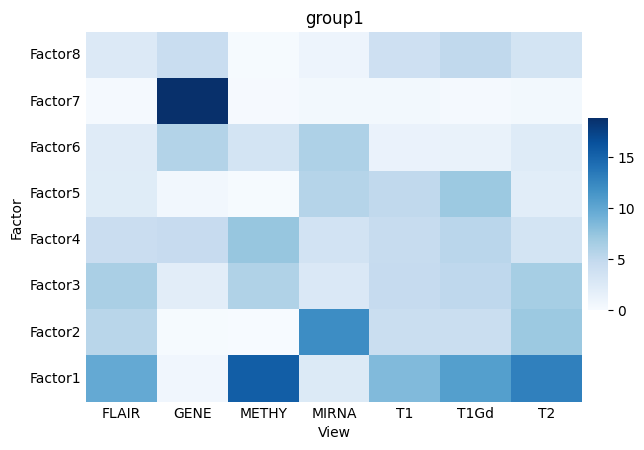

In [ ]:
mfx.plot_r2(m, x='View',factors=list(range(10)), cmap="Blues")

What insights from the data can we learn just from inspecting this plot?
- Factor 1 captures variability in almost all of the layers
- Factor 2 captures variability in the miRNA layer
- Factor 7 captures a strong source of variability in the GENE omics layer

We can also take a look at the R2 values for each view and factor or plot the R2 values vs. factors so that we can assess which factor captures the most variability.

In [ ]:
# display the R2 values in descending order
m.get_r2(factors=list(range(9))).sort_values("R2", ascending=False).head()

,Factor,View,Group,R2
43,Factor7,GENE,group1,18.790742
2,Factor1,METHY,group1,15.448353
6,Factor1,T2,group1,13.031955
10,Factor2,MIRNA,group1,12.098010
5,Factor1,T1Gd,group1,10.673563


<Axes: xlabel='Factor', ylabel='R2'>

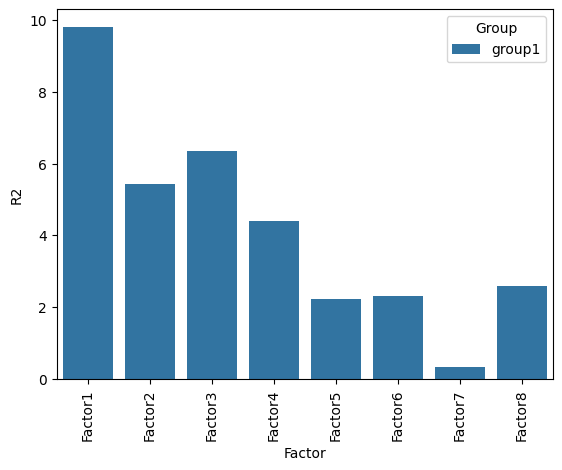

In [ ]:
# plot the R2 values vs factors
mfx.plot_r2_barplot(m)

#### Combination of factors

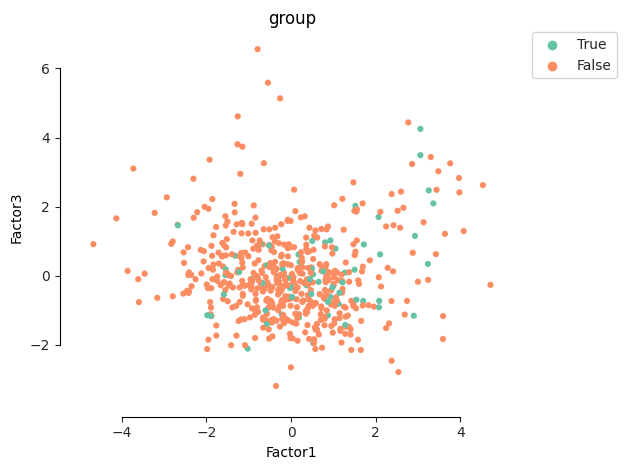

In [ ]:
#Visualisation of combinations of factors
m.metadata.group = m.metadata.CLI_CDE_chemo_alk_days_Medium
mfx.plot_factors_scatter(m,x="Factor1",y="Factor3")
m.metadata.group = 'group1'

In [ ]:
m.metadata

In [ ]:
m = mfx.mofa_model('/tmp/mofa_20230919-163731.hdf5')
m.metadata = m.metadata.join(cli)
covariates = m.metadata.astype(bool)

In [ ]:
mfx.plot_factors_covariates_correlation(m, covariates=covariates.iloc[:,30:50])

### **Survival Analysis**
We will now use the MOFA factors to build Cox Proportional Hazard models and evaluate the predictive performance. It computes the mean cross-validated C-index for each model on survival data, allowing for a comparison of their effectiveness. The results are sorted in descending order based on the C-index, providing insights into the relative performance of the models.

In [ ]:
import os
import mofax as mfx
from lifelines import CoxPHFitter
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from lifelines.utils import concordance_index

def cross_val_cox(model_factors, outcome_df, n_folds=10):
  """
  The function is used to perform k-fold cross-validation for Cox Proportional Hazards models,
  which are commonly employed in survival analysis. It assesses the performance of these models
  on survival data by calculating the Concordance Index (C-index) as an evaluation metric.
  The C-index measures the ability of the model to predict the relative order of survival times
  for individuals in the dataset.

  Parameters:
    model_factors (DataFrame): A DataFrame containing the factors (features) used for modeling survival data.
                              Each row represents an individual or sample, and each column represents a feature.
    outcome_df (DataFrame): A DataFrame containing the survival outcome data. It typically includes two columns:
                            'Survival' (time to event) and 'Death' (binary indicator of whether an event occurred).
    n_folds (int, optional, default=10): The number of folds for k-fold cross-validation. This parameter controls
                                        how the dataset is split into training and testing subsets. By default, it is set to 10.

  Returns:
    float: The mean Concordance Index (C-index) computed over all folds of cross-validation. A higher C-index indicates better predictive performance.
  """

    # Initialize KFold cross-validation
  kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

  c_indices = []  # Store C-index for each fold

  for train_idx, test_idx in kf.split(model_factors):
      train_factors, test_factors = model_factors.iloc[train_idx], model_factors.iloc[test_idx]
      train_outcome, test_outcome = outcome_df.iloc[train_idx], outcome_df.iloc[test_idx]

      # Initialize Cox model
      cph = CoxPHFitter()

      # Train the Cox model
      cph.fit(pd.concat([train_factors, train_outcome], axis=1), duration_col='Survival', event_col='Death')

      # Predict the hazard for test set
      hazards = cph.predict_partial_hazard(test_factors)

      # Compute the concordance index for this fold
      c_index = concordance_index(test_outcome['Survival'], -hazards, test_outcome['Death'])
      c_indices.append(c_index)

  # Compute mean C-index over all folds
  mean_c_index = np.mean(c_indices)

  return mean_c_index

# Loading the survival outcomes
survival = pd.read_csv(data_path + "/survival.csv",sep=',')
#Reading survival data

survival['PatientID'] = survival['PatientID'].str.upper() + '.01'

survival = survival.set_index('PatientID')

# Drop any rows with NaN values
survival.dropna(inplace=True)

# Assuming `outcome_df` is the outcome data with columns 'duration' and 'event'
results = {}
for key, model in all_models.items():
    print(f"Computing cross-validated C-index for {key}...")

    factors_array = model.get_factors()
    samples = model.get_samples()
    sample_names = samples['sample']

    # Convert numpy array to DataFrame with sample names as index
    factors = pd.DataFrame(factors_array, index=sample_names)

    # Ensure common patients between factors and outcome_df
    common_patients = factors.index.intersection(survival.index)
    factors = factors.loc[common_patients].dropna()
    filtered_outcome_df = survival.loc[common_patients]

    results[key] = cross_val_cox(factors, filtered_outcome_df)

# Print the results sorted by C-index
sorted_results = sorted(results.items(), key=lambda x: x[1], reverse=True)
for model_name, c_index in sorted_results:
    print(f"Model: {model_name}, Cross-validated C-index: {c_index:.4f}")


Computing cross-validated C-index for FLAIR_GENE_METHY_MIRNA_T1_T1Gd_T2...
Model: FLAIR_GENE_METHY_MIRNA_T1_T1Gd_T2, Cross-validated C-index: 0.6614


We will assess the robustness and predictive performance of multiple Cox Proportional Hazards models using bootstrap resampling. We first calculate the mean bootstrap cross-validated C-index for each model on survival data, enabling a comparison of their stability and effectiveness. The results are sorted in descending order based on the C-index, providing insights into the relative performance of the models under resampling conditions.

In [ ]:
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index
from sklearn.utils import resample

def bootstrap_cross_val_cox(model_factors, outcome_df, n_bootstrap=100, l2_penalty=0.1):
  """
  The function performs bootstrap cross-validation for Cox Proportional Hazards models,
  commonly used in survival analysis. It assesses the model's stability and predictive
  performance by resampling the dataset and computing the mean Concordance Index (C-index)
  across multiple iterations. The C-index measures the model's ability to predict the
  relative order of survival times for individuals in the dataset.

  Parameters:
    model_factors (DataFrame): A DataFrame containing the factors (features) used for
                                modeling survival data. Rows represent individuals, and
                                columns represent features.
    outcome_df (DataFrame): A DataFrame with survival outcome data, typically including
                            'Survival' (time to event) and 'Death' (binary event indicator) columns.
    n_bootstrap (int, optional, default=100): The number of bootstrap iterations to perform.
                                              Each iteration involves resampling the dataset to
                                              create a new training set.
    l2_penalty (float, optional, default=0.1): The L2 penalty parameter for the Cox model, which controls
                                              the regularization strength during model training.

  Returns:
    float: The mean Concordance Index (C-index) computed over all bootstrap iterations.
            A higher C-index indicates better predictive performance and model stability.
  """
  c_indices = []  # Store C-index for each bootstrap iteration

  for _ in range(n_bootstrap):
      # Bootstrap resample the data
      bootstrap_factors, bootstrap_outcome = resample(model_factors, outcome_df, replace=True)

      # Initialize Cox model with L2 penalty
      cph = CoxPHFitter(penalizer=l2_penalty)

      # Train the Cox model on bootstrap data
      cph.fit(pd.concat([bootstrap_factors, bootstrap_outcome], axis=1), duration_col='Survival', event_col='Death')

      # Predict the hazard for original data
      hazards = cph.predict_partial_hazard(model_factors)

      # Compute the concordance index for this bootstrap iteration
      c_index = concordance_index(outcome_df['Survival'], -hazards, outcome_df['Death'])
      c_indices.append(c_index)

  # Compute mean C-index over all bootstrap iterations
  mean_c_index = np.mean(c_indices)

  return mean_c_index

# Assuming `outcome_df` is the outcome data with columns 'Survival' and 'Death'
results = {}
for key, model in all_models.items():
    if key not in results.keys():
      print(f"Computing bootstrap cross-validated C-index for {key}...")
      try:
        factors_array = model.get_factors()
      except:
        continue
      samples = model.get_samples()
      sample_names = samples['sample']

      # Convert numpy array to DataFrame with sample names as index
      factors = pd.DataFrame(factors_array, index=sample_names)

      # Ensure common patients between factors and outcome_df
      common_patients = factors.index.intersection(survival.index)
      factors = factors.loc[common_patients].dropna()
      filtered_outcome_df = survival.loc[common_patients]

      results[key] = bootstrap_cross_val_cox(factors, filtered_outcome_df)

# Print the results sorted by C-index
sorted_results = sorted(results.items(), key=lambda x: x[1], reverse=True)
for model_name, c_index in sorted_results:
    print(f"Model: {model_name}, Bootstrap cross-validated C-index: {c_index:.4f}")

Computing bootstrap cross-validated C-index for FLAIR_GENE_METHY_MIRNA_T1_T1Gd_T2...
Model: FLAIR_GENE_METHY_MIRNA_T1_T1Gd_T2, Bootstrap cross-validated C-index: 0.6615


**Exercise**\
Apply the model on the test dataset.